# MODEL YARATMA

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, KFold, GroupKFold, StratifiedGroupKFold, ShuffleSplit, StratifiedShuffleSplit
import sklearn.datasets as skds
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd
import polars as pl
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [20]:
carlsen=pd.read_parquet("Carlsen V2.parquet")
nakamura=pd.read_parquet("Nakamura V2.parquet")
caruana=pd.read_parquet("Caruana V2.parquet")

In [21]:
categorical_columns = ["ECO","Game Class", "Phase", "Game Length", "Best Move Rate Classify", "Game Ending Reason"]
for column in categorical_columns:
    carlsen[column] = carlsen[column].astype("category")
    nakamura[column] = nakamura[column].astype("category")
    caruana[column] = caruana[column].astype("category")

In [22]:
carlsen['Player'] = 0   #'Carlsen'
nakamura['Player'] = 1  #'Nakamura'
caruana['Player'] = 2   #'Caruana'

In [23]:
# Kullanılacak olan sütunlar
selected_columns = ["ECO","Game Class", "Phase", "Game Length", "Best Move Rate Classify", "Game Ending Reason", "Player"]

carlsen_df_selected = carlsen[selected_columns]
nakamura_df_selected = nakamura[selected_columns]
caruana_df_selected = caruana[selected_columns]

In [24]:
carlsen_df_balanced = carlsen_df_selected.sample(n=min(4500, len(carlsen_df_selected)))
nakamura_df_balanced = nakamura_df_selected.sample(n=min(4500, len(nakamura_df_selected)))
caruana_df_balanced = caruana_df_selected.sample(n=min(4500, len(caruana_df_selected)))

In [25]:
all_players_df_selected = pd.concat([carlsen_df_balanced, nakamura_df_balanced, caruana_df_balanced])

In [26]:
# One-hot encoding işlemi
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
ohe.fit(all_players_df_selected[["ECO","Game Class", "Phase", "Game Length", "Best Move Rate Classify", "Game Ending Reason"]])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [27]:
X_encoded = pd.DataFrame(ohe.transform(all_players_df_selected[["ECO","Game Class", "Phase", "Game Length", "Best Move Rate Classify", "Game Ending Reason"]]),
                              columns = list(ohe.get_feature_names()))
y = all_players_df_selected["Player"]

/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [28]:
# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2,stratify=y)

In [29]:
model = LogisticRegression(max_iter=1000, multi_class='auto',solver= "newton-cg")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)                                              

In [30]:
accuracy = accuracy_score(y_test, y_pred)
print("Model Doğruluğu:", accuracy)   

Model Doğruluğu: 0.5207407407407407


In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.48      0.50       900
           1       0.54      0.55      0.54       900
           2       0.50      0.54      0.52       900

    accuracy                           0.52      2700
   macro avg       0.52      0.52      0.52      2700
weighted avg       0.52      0.52      0.52      2700



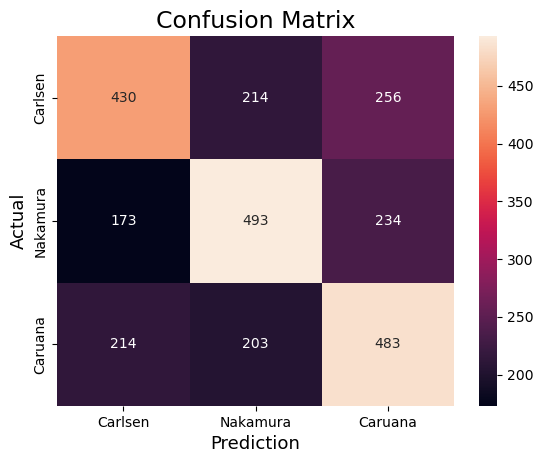

In [32]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['Carlsen','Nakamura','Caruana'],
            yticklabels=['Carlsen','Nakamura','Caruana']
           )
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [35]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from scipy.stats import t

def modeling_with_confidence_intervals(model, X, y, n_iterations=1000, test_size=0.2, random_state=42):
    accuracy_list = []
    precision_list = []
    recall_list = []

    for i in range(n_iterations):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state+i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy_list.append(accuracy_score(y_test, y_pred))
        precision_list.append(precision_score(y_test, y_pred, zero_division=0,average='weighted'))
        recall_list.append(recall_score(y_test, y_pred, zero_division=0,average='weighted'))

    metrics_df = pd.DataFrame({
        'accuracy': accuracy_list,
        'precision': precision_list,
        'recall': recall_list
    })

    mean_metrics = metrics_df.mean()
    sem_metrics = metrics_df.sem()
    
    confidence_intervals = {}
    confidence_level = 0.95
    degrees_freedom = n_iterations - 1
    t_critical = t.ppf((1 + confidence_level) / 2, degrees_freedom)
    
    for metric in mean_metrics.index:
        ci_margin = sem_metrics[metric] * t_critical
        confidence_intervals[metric] = (mean_metrics[metric] - ci_margin, mean_metrics[metric] + ci_margin)

    return metrics_df, confidence_intervals

In [40]:
modeling_with_confidence_intervals(model, X_encoded, y, n_iterations=30, test_size=0.2, random_state=45)

(    accuracy  precision    recall
 0   0.492963   0.493085  0.492963
 1   0.501111   0.502321  0.501111
 2   0.503704   0.504591  0.503704
 3   0.506296   0.507037  0.506296
 4   0.498519   0.499136  0.498519
 5   0.498519   0.498476  0.498519
 6   0.512593   0.513631  0.512593
 7   0.507407   0.507540  0.507407
 8   0.500370   0.501069  0.500370
 9   0.486296   0.487120  0.486296
 10  0.504074   0.503819  0.504074
 11  0.507037   0.508700  0.507037
 12  0.509630   0.511216  0.509630
 13  0.500741   0.500551  0.500741
 14  0.502222   0.502877  0.502222
 15  0.483333   0.484392  0.483333
 16  0.501852   0.502475  0.501852
 17  0.486296   0.486265  0.486296
 18  0.504074   0.505191  0.504074
 19  0.506667   0.507428  0.506667
 20  0.484815   0.485895  0.484815
 21  0.508148   0.509727  0.508148
 22  0.495556   0.495469  0.495556
 23  0.517407   0.517578  0.517407
 24  0.508148   0.508826  0.508148
 25  0.507778   0.508810  0.507778
 26  0.502963   0.505115  0.502963
 27  0.487407   0.48

# SVM MODEL

In [21]:
model = SVC(kernel='rbf',random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [22]:
accuracy = accuracy_score(y_test, y_pred)
print("SVM Model Doğruluğu:", accuracy)

SVM Model Doğruluğu: 0.515375854214123


# RANDOM FOREST

In [23]:
model = RandomForestClassifier(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [24]:
accuracy = accuracy_score(y_test, y_pred)
print("Model Doğruluğu:", accuracy) 

Model Doğruluğu: 0.48604783599088835


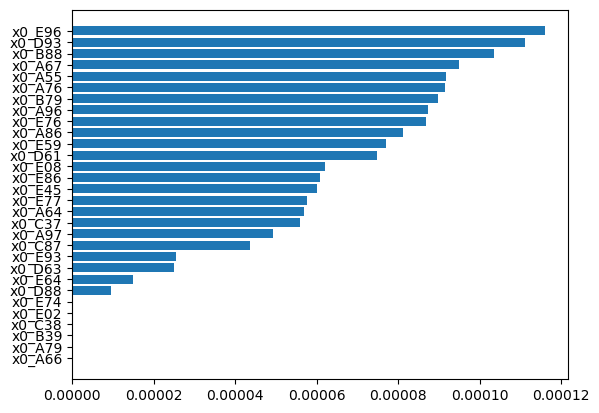

In [25]:
import matplotlib.pyplot as plt

f_i = list(zip(X_encoded.columns,model.feature_importances_))
f_i.sort(key = lambda x : x[1])
f_i = f_i[:30]
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

# SUPERVISED CLASSIFICATION MODELS TEST

In [26]:
X_encoded.columns

Index(['x0_A00', 'x0_A01', 'x0_A02', 'x0_A03', 'x0_A04', 'x0_A05', 'x0_A06',
       'x0_A07', 'x0_A08', 'x0_A09',
       ...
       'x3_medium-length', 'x3_miniature', 'x3_very long', 'x4_iyi', 'x4_kötü',
       'x4_orta', 'x4_çok iyi', 'x5_Mate', 'x5_Resign', 'x5_nan'],
      dtype='object', length=471)

In [27]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
#    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=10),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Naive Bayes': GaussianNB(),
#    'Neural Network': MLPClassifier(max_iter=10000)
    'AdaBoost':AdaBoostClassifier(n_estimators=10),
    'XGBoost': xgb.XGBClassifier(objective='binary:logistic', eval_metric='error'),
    'LightGBM':LGBMClassifier(num_leaves=10, n_estimators=50),
}

In [28]:
scoring = {'accuracy': make_scorer(accuracy_score), 
           'precision': make_scorer(precision_score, average='macro'),
           'recall': make_scorer(recall_score, average = 'macro'),
          }

In [29]:
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [30]:
# Function to evaluate models
def evaluate_model(X, y, model,strategy,n_folds=3):
    results = {}
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True)
    scores = cross_validate(strategy(model), X, y,
                            cv=cv,
                            scoring=scoring,
                            return_train_score=False,
                            n_jobs=-1,
                            verbose=1)


    
    results = {
#        'Model':model,
        'test_accuracy_std': np.std(scores['test_accuracy']),
        'test_accuracy_mean': np.mean(scores['test_accuracy']), 
        'test_accuracy_conf_interval': (np.mean(scores['test_accuracy']) - 1.96 * np.std(scores['test_accuracy']) / np.sqrt(len(scores['test_accuracy'])),
                          np.mean(scores['test_accuracy']) + 1.96 * np.std(scores['test_accuracy']) / np.sqrt(len(scores['test_accuracy']))),
        'test_precision_std': np.std(scores['test_precision']),
        'test_precision_mean': np.mean(scores['test_precision']), 
        'test_precision_conf_interval': (np.mean(scores['test_precision']) - 1.96 * np.std(scores['test_precision']) / np.sqrt(len(scores['test_precision'])),
                          np.mean(scores['test_precision']) + 1.96 * np.std(scores['test_precision']) / np.sqrt(len(scores['test_precision']))),
        'test_recall_std': np.std(scores['test_recall']),
        'test_recall_mean': np.mean(scores['test_recall']), 
        'test_recall_conf_interval': (np.mean(scores['test_recall']) - 1.96 * np.std(scores['test_recall']) / np.sqrt(len(scores['test_recall'])),
                          np.mean(scores['test_recall']) + 1.96 * np.std(scores['test_recall']) / np.sqrt(len(scores['test_recall']))),
        'fit_time': np.sum(scores['fit_time'])
    }
    return results

In [31]:
results = []
for model_name, model in models.items():
    for ensemble_type, ensemble_name in [(OneVsRestClassifier, 'One-vs-Rest'), (OneVsOneClassifier, 'One-vs-One')]:
        print(model)
        model_results = evaluate_model(X_encoded, y, model, ensemble_type,n_folds=5)
        result = {
            'Model': model_name,
            'Ensemble Type': ensemble_name,
            'Accuracy': model_results['test_accuracy_mean'],
            'Accuracy CI': model_results['test_accuracy_conf_interval'],
            'Precision': model_results['test_precision_mean'],
            'Precision CI': model_results['test_precision_conf_interval'],
            'Recall': model_results['test_recall_mean'],
            'Recall CI': model_results['test_recall_conf_interval'],
            'Time (s)': model_results['fit_time']
        }
        results.append(result)

LogisticRegression(max_iter=1000)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.4s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LogisticRegression(max_iter=1000)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.2s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


SVC(max_iter=1000)


/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anac

SVC(max_iter=1000)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with Stand

DecisionTreeClassifier(max_depth=10)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


DecisionTreeClassifier(max_depth=10)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RandomForestClassifier(n_estimators=10)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RandomForestClassifier(n_estimators=10)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


GradientBoostingClassifier()


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


GradientBoostingClassifier()


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   48.5s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.7s finished


GaussianNB()


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


GaussianNB()


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


AdaBoostClassifier(n_estimators=10)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.9s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


AdaBoostClassifier(n_estimators=10)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.8s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.9s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.4s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


LGBMClassifier(n_estimators=50, num_leaves=10)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See htt

LGBMClassifier(n_estimators=50, num_leaves=10)


/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


In [32]:
pd.DataFrame(results).sort_values(by=['Accuracy','Time (s)'],ascending = False)

,Model,Ensemble Type,Accuracy,Accuracy CI,Precision,Precision CI,Recall,Recall CI,Time (s)
0,Logistic Regression,One-vs-Rest,0.517799,"(0.5121637400084523, 0.5234344677719761)",0.500729,"(0.4943466120317197, 0.507111431993039)",0.484585,"(0.4781760195200621, 0.49099352964267035)",34.747620
1,Logistic Regression,One-vs-One,0.515749,"(0.5143707727655984, 0.5171266557522587)",0.497871,"(0.49415830676057854, 0.5015831234525951)",0.481969,"(0.48041863462917916, 0.4835186485263597)",19.226270
14,XGBoost,One-vs-Rest,0.510167,"(0.5082157578642602, 0.5121182850298914)",0.497986,"(0.493542366344154, 0.5024296601195952)",0.466790,"(0.46492646977475144, 0.46865350652124044)",36.004910
15,XGBoost,One-vs-One,0.508402,"(0.5014060578053121, 0.5153975253362495)",0.495096,"(0.4876214111323518, 0.5025703241902877)",0.467075,"(0.461471017534563, 0.4726780441046575)",19.467831
16,LightGBM,One-vs-Rest,0.501053,"(0.49638025207665265, 0.5057265012511573)",0.513931,"(0.5072156556788917, 0.520647333347153)",0.445951,"(0.44151874170682626, 0.4503826413888574)",13.914259
8,Gradient Boosting,One-vs-Rest,0.498776,"(0.49579396509373513, 0.5017571417757262)",0.525886,"(0.5185410154484145, 0.533231510014563)",0.439160,"(0.4356890497942029, 0.4426304881849759)",422.754933
9,Gradient Boosting,One-vs-One,0.498092,"(0.49285486226980485, 0.5033288856516318)",0.527965,"(0.5187401094318715, 0.5371908151405975)",0.437591,"(0.4320585650552928, 0.44312393293424807)",241.251883
17,LightGBM,One-vs-One,0.497807,"(0.49671158469434984, 0.49890271958461974)",0.502189,"(0.49261046274557696, 0.5117668999278169)",0.444720,"(0.44323057524212955, 0.44620871269437584)",11.484447
12,AdaBoost,One-vs-Rest,0.481289,"(0.4763878373480131, 0.4861901716299532)",0.510035,"(0.4908607751021356, 0.5292092002356678)",0.424235,"(0.4195716609047146, 0.4288991029310751)",17.806505
5,Decision Tree,One-vs-One,0.479296,"(0.4750650836985957, 0.48352633318903826)",0.488234,"(0.4694295988565827, 0.50703847485221)",0.421569,"(0.4166136927241061, 0.42652450451941704)",5.694531


# TUNED HYPERPARAMETER ANALYSIS

In [33]:
from sklearn.model_selection import GridSearchCV

In [34]:
# Define models and hyperparameter grids
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, multi_class='auto'),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'penalty': [None, 'l1', 'l2', 'elasticnet']
        }
    },
    'Support Vector Machine': {
        'model': SVC(max_iter=1000),
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'gamma': ['scale', 'auto']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [10, 50, 100],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': np.logspace(-9, 0, 10)
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [10, 50, 100],
            'learning_rate': [0.01, 0.1, 1]
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(objective='binary:logistic', eval_metric='error'),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'num_leaves': [10, 20, 31],
            'learning_rate': [0.01, 0.1]
        }
    }
}

In [35]:
# Iterate over models and perform hyperparameter tuning
best_estimators = {}
for name, model_info in models.items():
    print(f"Running GridSearchCV for {name}")
    grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=cv, n_jobs=-1, verbose=1)
    grid_search.fit(X_encoded, y)
    best_estimators[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}\n")

Running GridSearchCV for Logistic Regression
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}

Running GridSearchCV for Support Vector Machine
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anac

Best parameters for Support Vector Machine: {'C': 100, 'gamma': 'auto', 'kernel': 'poly'}

Running GridSearchCV for Decision Tree
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Decision Tree: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10}

Running GridSearchCV for Random Forest
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}

Running GridSearchCV for Naive Bayes
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Naive Bayes: {'var_smoothing': 0.1}

Running GridSearchCV for AdaBoost
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for AdaBoost: {'learning_rate': 1, 'n_estimators': 100}

Running GridSearchCV for XGBoost
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth

/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 392
[LightGBM] [Info] Number of data points in the train set: 17557, number of used features: 196
[LightGBM] [Info] Start training from score -1.131676
[LightGBM] [Info] Start training from score -0.876620
[LightGBM] [Info] Start training from score -1.342009
Best parameters for LightGBM: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 20}



In [36]:
best_estimators_results = []

for model_name, model in best_estimators.items():
    for ensemble_type, ensemble_name in [(OneVsRestClassifier, 'One-vs-Rest'), (OneVsOneClassifier, 'One-vs-One')]:
        print(f"Evaluating {model_name} with {ensemble_name}")
        model_results = evaluate_model(X_encoded, y, model, ensemble_type, n_folds=5)
        result = {
            'Model': model_name,
            'Ensemble Type': ensemble_name,
            'Accuracy': model_results['test_accuracy_mean'],
            'Accuracy CI': model_results['test_accuracy_conf_interval'],
            'Precision': model_results['test_precision_mean'],
            'Precision CI': model_results['test_precision_conf_interval'],
            'Recall': model_results['test_recall_mean'],
            'Recall CI': model_results['test_recall_conf_interval'],
            'Time (s)': model_results['fit_time']
        }
        best_estimators_results.append(result)

Evaluating Logistic Regression with One-vs-Rest


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.4s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Evaluating Logistic Regression with One-vs-One


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.9s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished


Evaluating Support Vector Machine with One-vs-Rest


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with Stand

Evaluating Support Vector Machine with One-vs-One


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with Stand

Evaluating Decision Tree with One-vs-Rest


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.4s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Evaluating Decision Tree with One-vs-One


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Evaluating Random Forest with One-vs-Rest


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   21.0s remaining:   31.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Evaluating Random Forest with One-vs-One


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.6s remaining:   16.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Evaluating Naive Bayes with One-vs-Rest


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Evaluating Naive Bayes with One-vs-One


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Evaluating AdaBoost with One-vs-Rest


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   34.2s remaining:   51.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Evaluating AdaBoost with One-vs-One


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   21.9s remaining:   32.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.0s finished


Evaluating XGBoost with One-vs-Rest


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ahmetsalihcoskun/opt/ana

Evaluating XGBoost with One-vs-One


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ahmetsalihcoskun/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py", line 742, in fit


Evaluating LightGBM with One-vs-Rest


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.4s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Evaluating LightGBM with One-vs-One


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.5s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished


In [37]:
tuned_models = pd.DataFrame(best_estimators_results).sort_values(by=['Accuracy','Time (s)'],ascending = False)

In [38]:
tuned_models

,Model,Ensemble Type,Accuracy,Accuracy CI,Precision,Precision CI,Recall,Recall CI,Time (s)
0,Logistic Regression,One-vs-Rest,0.517173,"(0.5106792298467477, 0.5236659034765077)",0.501049,"(0.4931141399094829, 0.508983121491773)",0.484008,"(0.47817087189494445, 0.48984448136907977)",46.131741
1,Logistic Regression,One-vs-One,0.514952,"(0.5063278146949802, 0.5235754700677148)",0.498402,"(0.48847124205548764, 0.508332379371546)",0.481764,"(0.4729268278133191, 0.49060185576731763)",28.433942
10,AdaBoost,One-vs-Rest,0.511022,"(0.5071118457481198, 0.5149312741827969)",0.500195,"(0.4965074187932247, 0.5038834767567041)",0.468757,"(0.4655256920083301, 0.47198838545201377)",165.790295
11,AdaBoost,One-vs-One,0.507205,"(0.5045136188661454, 0.5098961859192055)",0.498076,"(0.4955935069946874, 0.5005588661068109)",0.464871,"(0.46200958779201184, 0.46773207197884936)",100.184770
8,Naive Bayes,One-vs-Rest,0.505041,"(0.5008041343330155, 0.5092777495477133)",0.489915,"(0.4845075346668555, 0.49532317362500744)",0.464639,"(0.460279894268744, 0.46899815886811774)",2.233285
15,LightGBM,One-vs-One,0.504585,"(0.5008793047418745, 0.5082911903308844)",0.488823,"(0.48434054339440025, 0.4933062785171656)",0.463652,"(0.45878244985287814, 0.4685219122272141)",36.899683
7,Random Forest,One-vs-One,0.504415,"(0.4963021257108847, 0.5125273649429601)",0.486425,"(0.4774586631182463, 0.4953907984736495)",0.467930,"(0.46109984156614536, 0.47476007911150553)",50.013101
14,LightGBM,One-vs-Rest,0.501852,"(0.49325537706401834, 0.5104486666540976)",0.487225,"(0.47622276057036916, 0.49822759683213114)",0.459738,"(0.4516772972110407, 0.46779905143336925)",36.519529
9,Naive Bayes,One-vs-One,0.501509,"(0.4955976774579843, 0.5074212107871602)",0.485845,"(0.47826468532477173, 0.4934259254456246)",0.461757,"(0.45619979504065195, 0.467314855326964)",2.077031
6,Random Forest,One-vs-Rest,0.498092,"(0.4924800534301747, 0.5037042459634006)",0.478317,"(0.47114499836851775, 0.48548898126076667)",0.464305,"(0.4582690692022861, 0.47034100867697565)",103.202607


[LightGBM] [Info] Number of positive: 5846, number of negative: 4529
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 10375, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.563470 -> initscore=0.255257
[LightGBM] [Info] Start training from score 0.255257
[LightGBM] [Info] Number of positive: 3670, number of negative: 4529
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 256
[LightGBM] [Info] Number of data points in the train set: 8199, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.447616 -> initscore=-0.210310
[LightGBM

# BEST MODEL

In [ ]:
#best_model

# PICKLE CIKTISI ALMA

In [ ]:
import pickle

with open('onehot.pk', 'wb') as fin:
    pickle.dump(ohe, fin)

with open('model.pk', 'wb') as fin:
    pickle.dump(best_model, fin)

# ECO KONTROL VERISI

In [47]:
import chess
import requests
from bs4 import BeautifulSoup

In [ ]:
url = 'https://www.chessgames.com/chessecohelp.html'
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
response = requests.get(url, headers=headers)

In [ ]:
def convert_to_uci(moves):
    try:
        board = chess.Board()
        uci_moves = []
        for move in moves.split():
            if move in ['1','2','3','4','5','6','7','8','9','10']:  # Hamle numaralarını atla
                continue
            uci_move = board.parse_san(move).uci()
            board.push_uci(uci_move)
            uci_moves.append(uci_move)
        return ' '.join(uci_moves)
    except ValueError:
        return ""

In [58]:
if response.status_code == 200:
    html_content = response.content
    soup = BeautifulSoup(html_content, 'html.parser')
    
    title = soup.title.string
    eco_table = soup.find('table')  
    rows = eco_table.find_all('tr')[1:]  
    eco_codes = []

    for row in rows:
        cols = row.find_all('td')
        eco_code = cols[0].text.strip()
        description = cols[1].text.strip()
        if '\n' in description:
            name, moves = description.split('\n', 1)
        else:
            name, moves = description, ''
        eco_codes.append((eco_code, name, moves))

    df = pd.DataFrame(eco_codes, columns=['ECO Code', 'Description', 'Moves'])

In [59]:
df['UCI Moves'] = df['Moves'].apply(convert_to_uci)

In [61]:
df.to_parquet('ECO.parquet')